## 1. Importación de librerias
_____

In [1]:
import numpy as np
import pickle
import cv2
import tensorflow as tf 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.python.keras.saving import saving_utils
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, plot_confusion_matrix
import os 
from os import listdir

## 2. Cargar set de Imágenes
_____

In [2]:
# Dimensiones de las imágenes
DEFAULT_IMAGE_SIZE = tuple((256, 256))

# Número de imagenes a utilizar
N_IMAGES = 281

# Ruta de carpeta de imágenes
root_dir = 'Fotos'

#train_dir = os.path.join(root_dir, 'train')
#val_dir = os.path.join(root_dir, 'val')

#train_dir = 'Fotos'
#val_dir = 'Fotos'


## 3. Convertir images en arreglos
_____

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

## 4. Procesamiento de imágenes
-----
1. Identifación de carpetas 
2. Identificación de imágenes

In [4]:
image_list, label_list = [], []

try:
    print("[INFO] Procesamiento de imágenes...")
    plant_disease_folder_list = listdir(root_dir)
    
    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Identificación de carpetas {plant_disease_folder}...")
        
        if(plant_disease_folder != ".DS_Store"):
            plant_disease_image_list = listdir(f"{root_dir}/{plant_disease_folder}/")
            for image in plant_disease_image_list[:N_IMAGES]:
                image_directory = f"{root_dir}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpeg")==True or image_directory.endswith(".JPG")==True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)

    print("[INFO] Procesamiento de imagenes exitoso.")  
except Exception as e:
    print(f"Error : {e}")
    
# Transformación de las imágenes de entrenamiento, cargados en una matriz numpy
np_image_list = np.array(image_list, dtype=np.float16) / 225

# Comprobar del número de imágenes cargadas para el entrenamiento
image_len = len(image_list)
print(f"Cantidad de imágenes: {image_len}")

[INFO] Procesamiento de imágenes...
[INFO] Identificación de carpetas noSana...
[INFO] Identificación de carpetas otra...
[INFO] Identificación de carpetas sana...
[INFO] Procesamiento de imagenes exitoso.
Cantidad de imágenes: 281


## 5. Etiquetado
-----
1. Identifación de clases
2. Binarización de etiquetas

In [5]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))

n_classes = len(label_binarizer.classes_)

print("Número de clases de imágenes: ", n_classes)

Número de clases de imágenes:  3


## 6. Aumento de datos
-----

In [6]:
#augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
#                              height_shift_range=0.1, shear_range=0.2, 
#                              zoom_range=0.2, horizontal_flip=True, 
#                              fill_mode="nearest")
    
#augment = ImageDataGenerator()

# img_dir_path = "Fotos/no_sana"
# save_dir_path = "Fotos/train"

# train_generator = augment.flow_from_directory(
#     img_dir_path, 
#     target_size=(128, 128), 
#     color_mode="rgb", 
#     batch_size=20, 
#     save_to_dir="Respaldo", 
#     class_mode="binary", 
#     save_prefix="augmented", 
#     save_format="png")

# for i in range(10):
#     train_generator.next()

In [7]:
print("[INFO] Dividir el conjunto de datos en datos de entrenamiento y datos de prueba...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state=45)

[INFO] Dividir el conjunto de datos en datos de entrenamiento y datos de prueba...


In [8]:
# Establecer parámetros para el modelo
EPOCHS = 20
STEPS = 18
LR = 1e-3
BATCH_SIZE = 16
WIDTH = 256
HEIGHT = 256
DEPTH = 3

## 7. CREAR ARQUITECTURA
-----

In [9]:
model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

# Comprobar arquitectura
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

In [10]:
import keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# Activar el optimizador
opt = Adam(learning_rate=LR, decay=LR/EPOCHS)

# Compilar el modelo
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), f1_metric])

# Entrenar el modelo
print("[INFO] Entrenando al modelo...")
#history = model.fit(augment.flow(x_train, y_train, batch_size=BATCH_SIZE),
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE,
                    validation_data=(x_test, y_test),
                    steps_per_epoch=len(x_train) / BATCH_SIZE,
                    epochs=EPOCHS, verbose=1)

[INFO] Entrenando al modelo...
Epoch 1/20
14/14 [==============================] - 34s 2s/step - loss: 0.8660 - accuracy: 0.6205 - precision: 0.6341 - recall: 0.5804 - f1_metric: 0.6026 - val_loss: 0.4232 - val_accuracy: 0.7368 - val_precision: 0.7547 - val_recall: 0.7018 - val_f1_metric: 0.7401
Epoch 2/20
14/14 [==============================] - 32s 2s/step - loss: 0.5443 - accuracy: 0.7768 - precision: 0.8019 - recall: 0.7589 - f1_metric: 0.7796 - val_loss: 0.5549 - val_accuracy: 0.5614 - val_precision: 0.5536 - val_recall: 0.5439 - val_f1_metric: 0.5259
Epoch 3/20
14/14 [==============================] - 32s 2s/step - loss: 0.3998 - accuracy: 0.8616 - precision: 0.8807 - recall: 0.8571 - f1_metric: 0.8675 - val_loss: 1.0312 - val_accuracy: 0.5088 - val_precision: 0.5088 - val_recall: 0.5088 - val_f1_metric: 0.4896
Epoch 4/20
14/14 [==============================] - 32s 2s/step - loss: 0.3094 - accuracy: 0.8661 - precision: 0.8802 - recall: 0.8527 - f1_metric: 0.8661 - val_loss: 1.27

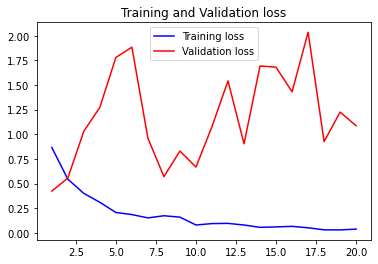

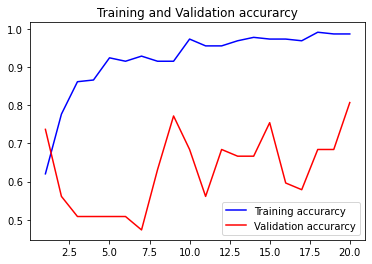

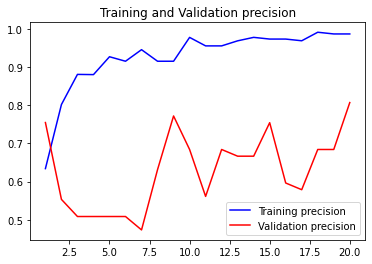

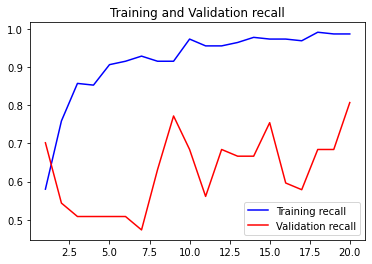

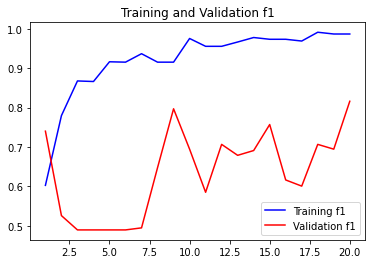

In [12]:
# Definir variables

loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

prec = history.history['precision']
val_prec = history.history['val_precision']

recall_1 = history.history['recall']
val_recall = history.history['val_recall']

f1 = history.history['f1_metric']
val_f1 = history.history['val_f1_metric']

epochs = range(1, len(acc) + 1)


# Pérdida de datos de entrenamiento y datos de prueba
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.figure()

# Precisión de los datos de entrenamiento y datos de prueba
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Precisión de los datos de entrenamiento y datos de prueba
plt.plot(epochs, prec, 'b', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and Validation precision')
plt.legend()

plt.figure()

# Precisión de los datos de entrenamiento y datos de prueba
plt.plot(epochs, recall_1, 'b', label='Training recall')
plt.plot(epochs, val_recall, 'r', label='Validation recall')
plt.title('Training and Validation recall')
plt.legend()

plt.figure()

# Precisión de los datos de entrenamiento y datos de prueba
plt.plot(epochs, f1, 'b', label='Training f1')
plt.plot(epochs, val_f1, 'r', label='Validation f1')
plt.title('Training and Validation f1')
plt.legend()

plt.show()

In [13]:
print("[INFO] Calcular la precisión del modelo....")
scores = model.evaluate(x_test, y_test)
print(f"Exactitud de la prueba: {scores[1]*100}")

[INFO] Calcular la precisión del modelo....
2/2 [==============================] - 2s 1s/step - loss: 1.0865 - accuracy: 0.8070 - precision: 0.8070 - recall: 0.8070 - f1_metric: 0.8194
Exactitud de la prueba: 80.70175647735596


In [14]:
# Guardar modelo
print("[INFO] Guardar modelo...")
model.save('model.h5')
#pickle.dump(model,open('cnn_model_a.pkl', 'wb'))


[INFO] Guardar modelo...


In [18]:
#model = tf.keras.models.load_model('model.h5')

Vgg16 = tf.keras.models.load_model('model.h5', compile=False)
Vgg16.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy' 
   ,tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), f1_metric])

#file_object = open('cnn_model_a.pkl', 'rb')
#model = pickle.load(file_object)

imgpath='../Fotos_Pruebas/hoja_hass_noSana.jpeg'

imar = convert_image_to_array(imgpath)
np_image_list = np.array([imar], dtype=np.float16) / 255

#predicted_classes = model.predict(np_image_list)

predicted_classes = Vgg16.predict(np_image_list)


#print(predicted_classes[0][2])
#predicted_classes[0][2] = 0


for i, img_tagged in enumerate(predicted_classes):
    print(img_tagged)
    print(max(img_tagged))
    print(label_binarizer.classes_[img_tagged.tolist().index(max(img_tagged))])

#print(label_binarizer.classes_[10])
#print (label_binarizer.classes_[PREDICTED_CLASSES2])

1/1 [==============================] - 1s 685ms/step
[9.999827e-01 9.501160e-06 7.721664e-06]
0.9999827
noSana
